## Plotting the Charts (health.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter('ignore')

In [2]:
file = os.path.join('demographics','regions.csv')
regions_df = pd.read_csv(file)

file = os.path.join('demographics','population.csv')
population_df = pd.read_csv(file)

file = os.path.join('health','diseases.csv')
diseases_df = pd.read_csv(file)

### X-Values: Population, Health

In [3]:
x_values = pd.merge(diseases_df, population_df, on=['Country_Code'], how='inner')
x_values.head()

,Country_Code,Non-communicable diseases (NCDs) (DALYs lost),Respiratory diseases (DALYs lost),Pop Density (per sqkm),Ages 0-9,Ages 10-19,Ages 20-29,Ages 30-39,Ages 40-49,Ages 50-59,Ages 60-69,Ages 70-79,Ages 80+,Population Total
0,AFG,6.948558e+06,359121.716381,56.937760,0.295644,0.254022,0.175506,0.114011,0.073628,0.046054,0.026612,0.011763,0.002760,37172388
1,ALB,6.276270e+05,25151.250839,104.612263,0.115932,0.135609,0.169658,0.126100,0.117269,0.137702,0.105786,0.064589,0.027355,2866376
2,DZA,7.036442e+06,330359.109288,17.730075,0.220813,0.147823,0.164383,0.167842,0.119867,0.084425,0.055158,0.026990,0.012701,42228429
3,AGO,4.181835e+06,227763.402362,24.713052,0.337316,0.236616,0.161649,0.111513,0.072069,0.044858,0.023043,0.010207,0.002731,30809764
4,ATG,1.778531e+04,594.414103,218.831818,0.149727,0.146995,0.153455,0.146061,0.144710,0.127324,0.076099,0.038585,0.017044,96282


In [4]:
x_values.loc[:,['Pop Density (per sqkm)']]

,Pop Density (per sqkm)
0,56.937760
1,104.612263
2,17.730075
3,24.713052
4,218.831818
...,...
168,24.009844
169,308.125246
170,53.977853
171,23.341479


### Y-Values: Confirmed, Fatalities (All Countries)

In [5]:
file = os.path.join('cases','all.ipynb')
%run '{file}'

In [12]:
def scatter_all(y_df, y_label, y_col, output_file):
    y_values = y_df.iloc[:,[21]]    # number of days from first case
    y_values.dropna(inplace=True)
    y_values.reset_index(inplace=True)
    y_values = pd.merge(regions_df, y_values, on=['Country_Region'], how='inner')

    merged_df = pd.merge(y_values, x_values, how='inner')

    selected_df = merged_df.loc[:, [21, y_col]]
    selected_df.dropna(inplace=True)

    x_scatter = selected_df.iloc[:,1]
    y_scatter = selected_df.iloc[:,0]

    fig, ax = plt.subplots(figsize = (9,6))
    
    if (y_label=='Confirmed Cases'):
        mcolor = 'coral'
    else:
        mcolor = None
  
    if ('Ages' in y_col):
        y_col = y_col + " (% of Population)"
    
    plt.scatter(x_scatter, y_scatter, s=150, color=mcolor, alpha=0.8)
    
#     plt.title(y_col, fontsize=18)
    plt.xlabel(y_col, labelpad=20, fontsize=16)
    plt.ylabel(y_label, labelpad=5, fontsize=14)
    plt.xlim(x_scatter.max()*-0.03, x_scatter.max()*1.03)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, p: format(int(y), ',')))

    ax.tick_params(axis='both', labelsize=14)

    file = os.path.join('..', 'images', output_file)
    plt.savefig(file, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

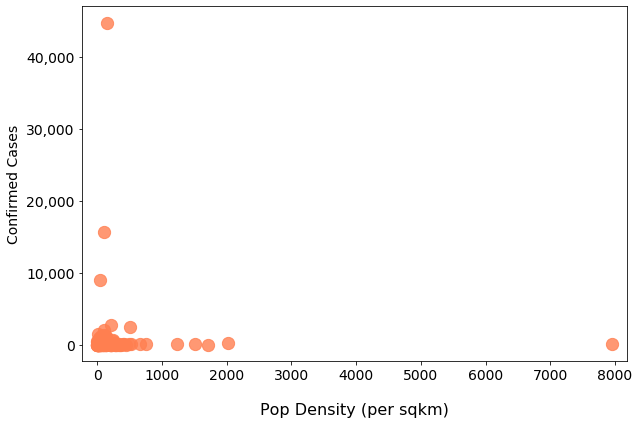

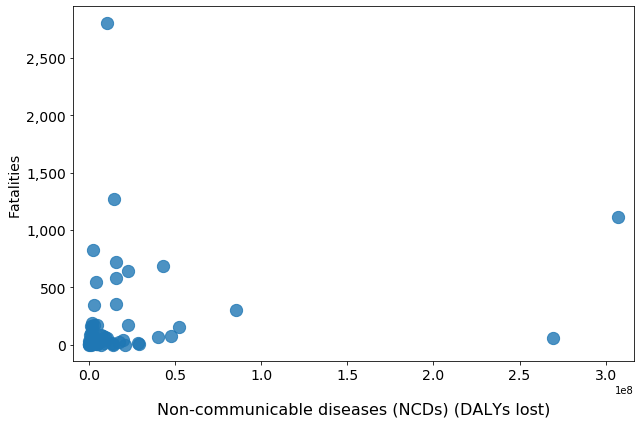

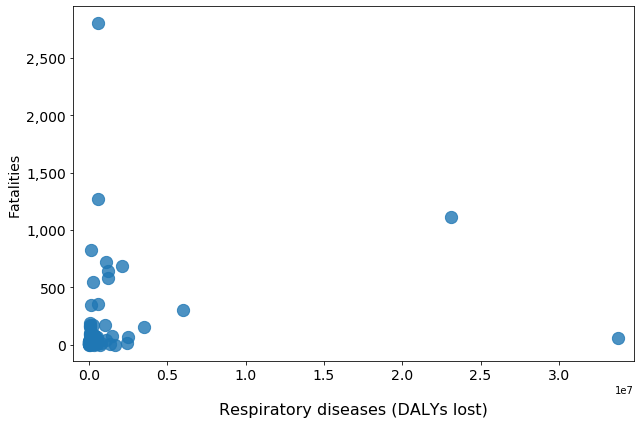

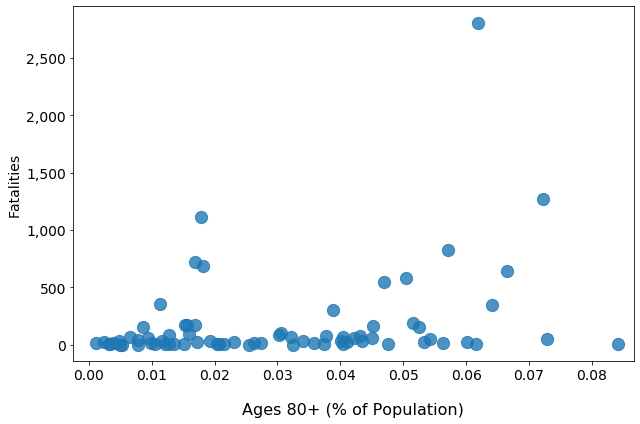

In [13]:
scatter_all(first_confirmed_all, 'Confirmed Cases', 'Pop Density (per sqkm)', 'scatter_popdensity.png')
scatter_all(first_fatalities_all, 'Fatalities', 'Non-communicable diseases (NCDs) (DALYs lost)', 'scatter_ncds.png')
scatter_all(first_fatalities_all, 'Fatalities', 'Respiratory diseases (DALYs lost)', 'scatter_resps.png')
scatter_all(first_fatalities_all, 'Fatalities', 'Ages 80+', 'scatter_age.png')

## Machine Learning Test

In [156]:
selected_features = [
#      'Non-communicable diseases (NCDs) (DALYs lost)',
#      'Respiratory diseases (DALYs lost)',
     'Pop Density (per sqkm)',
#      'Ages 70-79',
#      'Ages 80+',
#      'Health Expenditure (USD)',
#      'Hospital beds (per 1,000)',
]

y_values = confirmed_df.iloc[:,[21]]    # number of days from first case
y_values.dropna(inplace=True)
y_values.reset_index(inplace=True)
y_values = pd.merge(regions_df, y_values, on=['Country_Region'], how='inner')

In [157]:
merged_df = pd.merge(y_values, x_values, how='inner')

In [161]:
y_values

,Country_Code,Country_Region,Region,2/12/20
0,AFG,Afghanistan,South Asia,0
1,AGO,Angola,Sub-Saharan Africa,0
2,ALB,Albania,Europe & Central Asia,0
3,AND,Andorra,Europe & Central Asia,0
4,ARE,United Arab Emirates,Middle East & North Africa,8
...,...,...,...,...
174,XKX,Kosovo,Europe & Central Asia,0
175,YEM,Yemen,Middle East & North Africa,0
176,ZAF,South Africa,Sub-Saharan Africa,0
177,ZMB,Zambia,Sub-Saharan Africa,0


In [163]:
selected_df = merged_df.loc[:, [3, selected_features[0]]]
selected_df.dropna(inplace=True)
selected_df

,3,Pop Density (per sqkm)


In [159]:
    
# Initialize features array
X = []

# For each row in the df
for row in range(len(merged_df)):

    point = []

    # Append each indicator value to the data point
    for i in range(len(selected_features)):
        point.append(merged_df[selected_features[i]][row])
        
    # Append the row to the features array
    X.append(point)

X

[[56.93776001],
 [24.71305206],
 [104.6122628],
 [135.6091101],
 [16.2585101],
 [103.6802248],
 [218.83181820000001],
 [3.249129487],
 [107.2069267],
 [120.26531990000001],
 [435.178271],
 [377.2149273],
 [101.8539198],
 [72.19128289],
 [1239.5793119999998],
 [64.70353721],
 [2017.2737],
 [38.52547453],
 [64.92048828],
 [46.7287999],
 [16.79399386],
 [10.48014585],
 [25.06171624],
 [666.6069767000001],
 [81.39696395],
 [19.77752777],
 [3.977424876],
 [7.490412212000001],
 [4.075308214],
 [215.5213784],
 [25.18944607],
 [148.34883330000002],
 [78.83405346],
 [53.34398891],
 [37.08259236],
 [15.35684627],
 [44.74870212],
 [134.9297767],
 [97.91306306],
 [108.9995962],
 [128.7083333],
 [137.60288789999998],
 [237.37096980000004],
 [41.36842105],
 [138.0673017],
 [219.9785759],
 [17.73007507],
 [68.78868175],
 [98.87346929],
 [31.82150495],
 [93.52905826],
 [30.38610536],
 [109.22455900000001],
 [18.15685565],
 [48.35703339],
 [122.33839569999999],
 [8.224764233],
 [274.82739219999996],
 [

In [ ]:
# Installations you may need to run this notebook
# !pip install keras
# !pip install tensorflow
# !pip install sklearn --upgrade
# !pip install joblib

In [162]:
X = np.array(X)

y = np.array(selected_df.iloc[:,3])
y = y.reshape(-1, 1)

print(X.shape)
print(y.shape)

IndexError: single positional indexer is out-of-bounds

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

# Transform the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the model using LinearRegression
linear = LinearRegression()

# Train the model
linear.fit(X_train_scaled, y_train_scaled)

# Use our model to make predictions
predictions = linear.predict(X_test_scaled)

# Score the model
training_score = model.score(X_train_scaled, y_train_scaled)
testing_score = model.score(X_test_scaled, y_test_scaled)
r2 = linear.score(X_test_scaled, y_test_scaled)
mse = mean_squared_error(y_test_scaled, predictions)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print(f"R2 Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
# print(f"Linear Coefficient: {linear.coef_[0][0]}")
# print(f"y-Axis Intercept: {linear.intercept_[0]}")